In [ ]:
# -*- coding: utf-8 -*-
"""
DQN Gomoku Script with MPS Acceleration

Includes:
1. SuperTicTacToeEnv environment definition
2. DQN network definition
3. train_dqn function: trains model on MPS/CPU, records avg loss per episode and periodic win rate vs random
4. check_convergence function: checks convergence
5. play_human_vs_model: interactive play using action indices
6. play_against_random: evaluation vs random player
7. Main entry: select device (MPS/CPU), train, convergence check, plot loss & win rate, random eval, optional human play
"""

import numpy as np
import gym
from gym import spaces
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp

# ---------- Device Setup for MPS (Mac) ----------
device = "cpu"

# ---------- Environment Definition ----------
class SuperTicTacToeEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.board_shape = (12, 12)
        self.action_space = spaces.Discrete(80)
        self.observation_space = spaces.Box(low=0, high=2, shape=self.board_shape, dtype=np.int32)
        self.centers = [(0, 4), (4, 0), (4, 4), (4, 8), (8, 4)]

    def reset(self):
        self.board = np.full(self.board_shape, -1, dtype=np.int32)
        for (sr, sc) in self.centers:
            self.board[sr:sr+4, sc:sc+4] = 0
        self.current_player = 1
        return self.board.copy()

    def step(self, action):
        region = action // 16
        offset = action % 16
        r = self.centers[region][0] + offset // 4
        c = self.centers[region][1] + offset % 4
        # Place piece with 50% probability, else try neighbor
        if np.random.rand() < 0.5:
            self.board[r, c] = 1
        else:
            neighbors = [(r+dr, c+dc) for dr in [-1,0,1] for dc in [-1,0,1] if (dr,dc)!=(0,0)]
            random.shuffle(neighbors)
            placed = False
            for nr, nc in neighbors:
                if 0 <= nr < 12 and 0 <= nc < 12 and self.board[nr, nc] == 0:
                    self.board[nr, nc] = 1
                    placed = True
                    break
            if not placed:
                self.current_player = 3 - self.current_player
                return self.board.copy(), -0.01, False, {}
        # Check win
        if self.check_winner():
            return self.board.copy(), 1, True, {}
        # Switch player and flip perspective
        self.current_player = 3 - self.current_player
        self.board = np.where(self.board == 2, 3, self.board)
        self.board = np.where(self.board == 1, 2, self.board)
        self.board = np.where(self.board == 3, 1, self.board)
        return self.board.copy(), 0, False, {}

    def check_winner(self):
        for i in range(12):
            for j in range(12):
                if j+3 < 12 and all(self.board[i, j+k] == 1 for k in range(4)): return True
                if i+3 < 12 and all(self.board[i+k, j] == 1 for k in range(4)): return True
                if i+4 < 12 and j+4 < 12 and all(self.board[i+k, j+k] == 1 for k in range(5)): return True
                if i-4 >= 0 and j+4 < 12 and all(self.board[i-k, j+k] == 1 for k in range(5)): return True
        return False

    def print_action_board(self):
        grid = [['  ']*12 for _ in range(12)]
        for a in range(80):
            region = a//16; offset = a%16
            r = self.centers[region][0] + offset//4
            c = self.centers[region][1] + offset%4
            grid[r][c] = f"{a:2d}"
        for row in grid: print(' '.join(row))

    def plot_board(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        for sr, sc in self.centers:
            for i in range(5): ax.plot([sc-0.5, sc+3.5], [sr+i-0.5, sr+i-0.5], color='black')
            for j in range(5): ax.plot([sc+j-0.5, sc+j-0.5], [sr-0.5, sr+3.5], color='black')
        for sr, sc in self.centers:
            for dx in range(4):
                for dy in range(4):
                    r, c = sr+dx, sc+dy
                    v = self.board[r, c]
                    if v == 1: ax.text(c, r, 'X', ha='center', va='center', fontsize=14)
                    elif v == 2: ax.text(c, r, 'O', ha='center', va='center', fontsize=14)
        all_x = [sc+i for sc, _ in self.centers for i in range(4)]
        all_y = [sr+i for sr, _ in self.centers for i in range(4)]
        ax.set_xlim(min(all_x)-0.5, max(all_x)+0.5)
        ax.set_ylim(max(all_y)+0.5, min(all_y)-0.5)
        plt.show()

# ---------- DQN Model ----------
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(input_shape[0]*input_shape[1], 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, n_actions)
    def forward(self, x):
        x = x.to(device)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.out(x)

# ---------- Training with MPS Evaluation ----------
def train_dqn(env, model, target_model, episodes=500, lr=1e-3, gamma=0.99,
              batch_size=64, eval_interval=100, eval_games=1000):
    model.to(device); target_model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    replay = deque(maxlen=1000)
    epsilon = 1.0
    loss_per_episode = []
    eval_eps = []
    win_rates = []
    for ep in tqdm(range(1, episodes+1), desc='Training'):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        done = False
        ep_losses = []
        while not done:
            if random.random() < epsilon:
                a = env.action_space.sample()
            else:
                with torch.no_grad(): a = int(model(state).argmax().item())
            ns, r, done, _ = env.step(a)
            ns_tensor = torch.tensor(ns, dtype=torch.float32).unsqueeze(0).to(device)
            replay.append((state, a, r, ns_tensor, done))
            state = ns_tensor
            if len(replay) >= batch_size:
                batch = random.sample(replay, batch_size)
                s_batch, a_batch, r_batch, ns_batch, d_batch = zip(*batch)
                s = torch.cat(s_batch, dim=0)
                a_t = torch.tensor(a_batch, device=device)
                r_t = torch.tensor(r_batch, device=device)
                ns_t = torch.cat(ns_batch, dim=0)
                d_t = torch.tensor(d_batch, device=device)
                q_vals = model(s).gather(1, a_t.unsqueeze(1)).squeeze()
                next_q = target_model(ns_t).max(1)[0]
                targets = r_t + gamma * next_q * (~d_t)
                loss = F.mse_loss(q_vals, targets.detach())
                optimizer.zero_grad(); loss.backward(); optimizer.step()
                ep_losses.append(loss.item())
        loss_per_episode.append(np.mean(ep_losses) if ep_losses else 0)
        if ep % 10 == 0: target_model.load_state_dict(model.state_dict())
        epsilon = max(0.01, epsilon * 0.995)
        if ep % eval_interval == 0:
            res = play_against_random(env, model, num_games=eval_games)
            eval_eps.append(ep); win_rates.append(res['dqn']/eval_games)
    return loss_per_episode, eval_eps, win_rates

# ---------- Convergence Check ----------
def check_convergence(loss_per_episode, threshold=0.01):
    if len(loss_per_episode) < 2: return False
    mid = len(loss_per_episode)//2
    prev = np.mean(loss_per_episode[:mid]); recent = np.mean(loss_per_episode[mid:])
    rate = abs(recent-prev)/prev if prev!=0 else float('inf')
    plt.figure(figsize=(8,4)); plt.plot(loss_per_episode); plt.xlabel('Episode'); plt.ylabel('Avg Loss'); plt.title('Convergence'); plt.show()
    print(f"Change rate: {rate:.2%}")
    return rate < threshold

# ---------- Random vs DQN ----------
def play_against_random(env, model, num_games=100):
    res = {'dqn':0,'random':0,'draw':0}
    for _ in range(num_games):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        done=False; cur=env.current_player; reward=0
        while not done:
            if cur==1:
                with torch.no_grad(): vals=model(state)[0]
                acts=[i for i in range(80) if env.board[i//12, i%12]==0]
                a=max(acts, key=lambda x: vals[x].item())
            else:
                acts=[i for i in range(80) if env.board[i//12, i%12]==0]
                a= random.choice(acts)
            ns, reward, done, _ = env.step(a)
            state = torch.tensor(ns, dtype=torch.float32).unsqueeze(0).to(device)
            cur = env.current_player
        if reward==1:
            winner = 3 - cur
            res['dqn'] += (winner==1)
            res['random'] += (winner==2)
        else: res['draw'] += 1
    return res

# ---------- Human vs DQN ----------
def play_human_vs_model(model):
    env = SuperTicTacToeEnv()
    print("Action board indices:")
    env.print_action_board()
    side = int(input('Choose 1 for X, 2 for O: ') or 1)
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    done=False; human=side
    while not done:
        env.plot_board()
        if env.current_player==human:
            a=int(input('Enter action index (0-79): '))
            if a<0 or a>=80: print("Invalid"); continue
            r,c=env.centers[a//16][0]+(a%16)//4, env.centers[a//16][1]+(a%16)%4
            if env.board[r,c]!=0: print("Not available"); continue
        else:
            with torch.no_grad(): vals=model(state)[0]
            acts=[i for i in range(80) if env.board[i//12, i%12]==0]
            a = max(acts, key=lambda x: vals[x].item()); print(f"AI picks {a}")
        ns,_,done,_ = env.step(a)
        state = torch.tensor(ns, dtype=torch.float32).unsqueeze(0).to(device)
    env.plot_board()


In [ ]:
env=SuperTicTacToeEnv()
model=DQN(env.observation_space.shape, env.action_space.n).to(device)
target=DQN(env.observation_space.shape, env.action_space.n).to(device)
target.load_state_dict(model.state_dict())

# 几次连续训练
num_runs = 10

# 训练参数
episodes_per_run = 1000
eval_interval    = 100
eval_games       = 500

# 用来累积所有 runs 的结果
all_loss_ep = []
all_eps     = []
all_wr      = []

for run in range(num_runs):
    print(f"=== Run {run+1}/{num_runs} ===")
    
    # 如果想每次都从头训练（独立实验），可以在这里重新初始化 model/target
    # model = DQN(env.observation_space.shape, env.action_space.n).to(device)
    # target = DQN(env.observation_space.shape, env.action_space.n).to(device)
    # target.load_state_dict(model.state_dict())
    
    loss_ep, eps, wr = train_dqn(
        env, model, target,
        episodes=episodes_per_run,
        eval_interval=eval_interval,
        eval_games=eval_games
    )
    
    # 拼接 loss（直接 extend）
    all_loss_ep.extend(loss_ep)
    
    # eps 是 [100,200,…,5000]，要把第 run 次的 x 轴往后偏移
    shift = run * episodes_per_run
    all_eps.extend([e + shift for e in eps])
    
    # win rate 也直接 extend
    all_wr.extend(wr)

print("所有 runs 完成，开始画图…")

# —— 画合并后的 loss 曲线 —— #
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(all_loss_ep) + 1), all_loss_ep)
plt.xlabel('Episode')
plt.ylabel('Avg Loss')
plt.title(f'Combined Loss over {num_runs}×{episodes_per_run} Episodes')
plt.show()

# —— 画合并后的 win rate 曲线 —— #
plt.figure(figsize=(8, 4))
plt.plot(all_eps, all_wr, marker='o')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.title(f'Combined Win Rate (eval every {eval_interval} eps)')
plt.show()

In [12]:
import json
from tqdm import tqdm

iterate_num = 100
all_runs_results = []  # 用來存每次 iterate 的累積結果

for i in tqdm(range(iterate_num)):
    env = SuperTicTacToeEnv()
    model = DQN(env.observation_space.shape, env.action_space.n).to(device)
    target = DQN(env.observation_space.shape, env.action_space.n).to(device)
    target.load_state_dict(model.state_dict())

    num_runs = 10
    episodes_per_run = 1000
    eval_interval = 100
    eval_games = 500

    all_loss_ep = []
    all_eps = []
    all_wr = []

    for run in range(num_runs):
        print(f"=== Iterate {i+1}, Run {run+1}/{num_runs} ===")

        loss_ep, eps, wr = train_dqn(
            env, model, target,
            episodes=episodes_per_run,
            eval_interval=eval_interval,
            eval_games=eval_games
        )

        # 拼接累積
        all_loss_ep.extend(loss_ep)
        
        # eps 需要偏移，避免重複episode數
        shift = run * episodes_per_run
        all_eps.extend([e + shift for e in eps])
        
        all_wr.extend(wr)

    # 把該 iterate 的累積結果存入 all_runs_results
    iterate_result = {
        "iterate_index": i,
        "loss": all_loss_ep,
        "eps": all_eps,
        "win_rate": all_wr
    }
    all_runs_results.append(iterate_result)
    # 最後將所有 iterate 的結果存成 JSON
    with open("training_results.json", "w") as f:
        json.dump(all_runs_results, f)



  0%|          | 0/100 [00:00<?, ?it/s]

=== Iterate 1, Run 1/10 ===


Training: 100%|██████████| 1000/1000 [15:19<00:00,  1.09it/s]


=== Iterate 1, Run 2/10 ===


Training: 100%|██████████| 1000/1000 [23:09<00:00,  1.39s/it]


=== Iterate 1, Run 3/10 ===


Training: 100%|██████████| 1000/1000 [20:44<00:00,  1.24s/it]


=== Iterate 1, Run 4/10 ===


Training: 100%|██████████| 1000/1000 [08:47<00:00,  1.90it/s]


=== Iterate 1, Run 5/10 ===


Training: 100%|██████████| 1000/1000 [08:58<00:00,  1.86it/s]


=== Iterate 1, Run 6/10 ===


Training: 100%|██████████| 1000/1000 [08:23<00:00,  1.99it/s]


=== Iterate 1, Run 7/10 ===


Training: 100%|██████████| 1000/1000 [07:20<00:00,  2.27it/s]


=== Iterate 1, Run 8/10 ===


Training: 100%|██████████| 1000/1000 [07:29<00:00,  2.22it/s]


=== Iterate 1, Run 9/10 ===


Training: 100%|██████████| 1000/1000 [07:21<00:00,  2.27it/s]


=== Iterate 1, Run 10/10 ===


  1%|          | 1/100 [1:54:46<189:22:48, 6886.55s/it]

=== Iterate 2, Run 1/10 ===


Training: 100%|██████████| 1000/1000 [13:06<00:00,  1.27it/s]


=== Iterate 2, Run 2/10 ===


Training: 100%|██████████| 1000/1000 [18:52<00:00,  1.13s/it]


=== Iterate 2, Run 3/10 ===


Training: 100%|██████████| 1000/1000 [28:20<00:00,  1.70s/it]


=== Iterate 2, Run 4/10 ===


Training: 100%|██████████| 1000/1000 [17:13<00:00,  1.03s/it]


=== Iterate 2, Run 5/10 ===


Training: 100%|██████████| 1000/1000 [09:51<00:00,  1.69it/s]


=== Iterate 2, Run 6/10 ===


Training: 100%|██████████| 1000/1000 [08:31<00:00,  1.95it/s]


=== Iterate 2, Run 7/10 ===


Training: 100%|██████████| 1000/1000 [08:53<00:00,  1.87it/s]


=== Iterate 2, Run 8/10 ===


Training: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]


=== Iterate 2, Run 9/10 ===


Training: 100%|██████████| 1000/1000 [07:25<00:00,  2.25it/s]


=== Iterate 2, Run 10/10 ===


  2%|▏         | 2/100 [4:01:49<199:15:50, 7319.90s/it]

=== Iterate 3, Run 1/10 ===


Training: 100%|██████████| 1000/1000 [13:05<00:00,  1.27it/s]


=== Iterate 3, Run 2/10 ===


Training: 100%|██████████| 1000/1000 [15:20<00:00,  1.09it/s]


=== Iterate 3, Run 3/10 ===


Training: 100%|██████████| 1000/1000 [25:27<00:00,  1.53s/it]


=== Iterate 3, Run 4/10 ===


Training: 100%|██████████| 1000/1000 [21:09<00:00,  1.27s/it]


=== Iterate 3, Run 5/10 ===


Training: 100%|██████████| 1000/1000 [09:37<00:00,  1.73it/s]


=== Iterate 3, Run 6/10 ===


Training: 100%|██████████| 1000/1000 [09:23<00:00,  1.78it/s]


=== Iterate 3, Run 7/10 ===


Training: 100%|██████████| 1000/1000 [08:48<00:00,  1.89it/s]


=== Iterate 3, Run 8/10 ===


Training: 100%|██████████| 1000/1000 [08:07<00:00,  2.05it/s]


=== Iterate 3, Run 9/10 ===


Training: 100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s]


=== Iterate 3, Run 10/10 ===


  3%|▎         | 3/100 [6:07:48<200:10:06, 7428.94s/it]

=== Iterate 4, Run 1/10 ===


Training: 100%|██████████| 1000/1000 [14:44<00:00,  1.13it/s]


=== Iterate 4, Run 2/10 ===


Training: 100%|██████████| 1000/1000 [19:55<00:00,  1.20s/it]


=== Iterate 4, Run 3/10 ===


Training: 100%|██████████| 1000/1000 [30:55<00:00,  1.86s/it]


=== Iterate 4, Run 4/10 ===


Training: 100%|██████████| 1000/1000 [20:36<00:00,  1.24s/it]


=== Iterate 4, Run 5/10 ===


Training: 100%|██████████| 1000/1000 [09:23<00:00,  1.78it/s]


=== Iterate 4, Run 6/10 ===


Training: 100%|██████████| 1000/1000 [09:07<00:00,  1.82it/s]


=== Iterate 4, Run 7/10 ===


Training: 100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


=== Iterate 4, Run 8/10 ===


Training: 100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s]


=== Iterate 4, Run 9/10 ===


Training: 100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s]


=== Iterate 4, Run 10/10 ===


  4%|▍         | 4/100 [8:23:12<205:25:20, 7703.34s/it]

=== Iterate 5, Run 1/10 ===


Training: 100%|██████████| 1000/1000 [14:17<00:00,  1.17it/s]


=== Iterate 5, Run 2/10 ===


Training: 100%|██████████| 1000/1000 [23:33<00:00,  1.41s/it]


=== Iterate 5, Run 3/10 ===


Training: 100%|██████████| 1000/1000 [19:55<00:00,  1.20s/it]


=== Iterate 5, Run 4/10 ===


Training: 100%|██████████| 1000/1000 [09:27<00:00,  1.76it/s]


=== Iterate 5, Run 5/10 ===


Training: 100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s]


=== Iterate 5, Run 6/10 ===


Training: 100%|██████████| 1000/1000 [08:10<00:00,  2.04it/s]


=== Iterate 5, Run 7/10 ===


Training: 100%|██████████| 1000/1000 [07:39<00:00,  2.18it/s]


=== Iterate 5, Run 8/10 ===


Training: 100%|██████████| 1000/1000 [07:27<00:00,  2.24it/s]


=== Iterate 5, Run 9/10 ===


Training: 100%|██████████| 1000/1000 [07:31<00:00,  2.22it/s]


=== Iterate 5, Run 10/10 ===


  5%|▌         | 5/100 [10:17:55<195:28:42, 7407.60s/it]

=== Iterate 6, Run 1/10 ===


Training: 100%|██████████| 1000/1000 [14:03<00:00,  1.19it/s]


=== Iterate 6, Run 2/10 ===


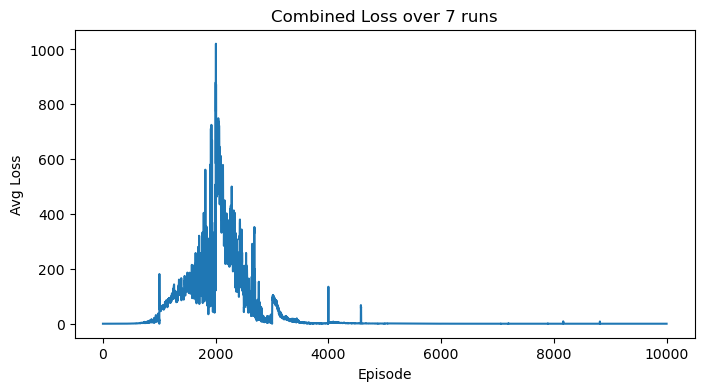

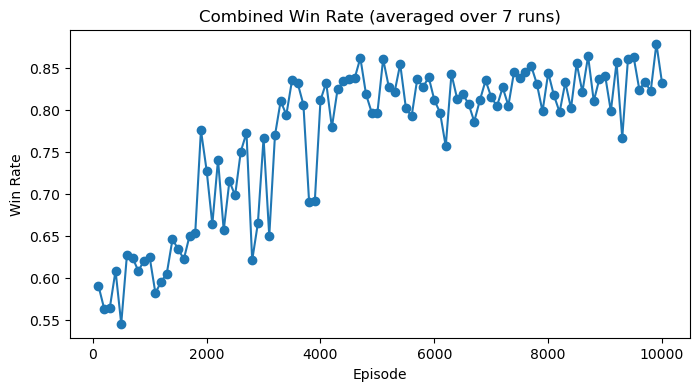

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# 读取 JSON 文件
with open("training_results.json", "r") as f:
    all_runs_results = json.load(f)

# 假设所有 iterate 的 episode 数目相同
num_iterates = len(all_runs_results)
num_episodes = len(all_runs_results[0]['loss'])

# 构造 numpy array 方便计算均值
all_loss = np.array([run['loss'] for run in all_runs_results])  # shape: (num_iterates, num_episodes)
all_win_rate = np.array([run['win_rate'] for run in all_runs_results])  # shape: (num_iterates, num_episodes)

# 计算每个 episode 的均值
mean_loss = np.mean(all_loss, axis=0)
mean_win_rate = np.mean(all_win_rate, axis=0)

# 取出 episode 数组（假设所有 iterate 的 eps 一致）
all_eps = all_runs_results[0]['eps']

# 画合并后的 loss 曲线
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_episodes + 1), mean_loss)
plt.xlabel('Episode')
plt.ylabel('Avg Loss')
plt.title(f'Combined Loss over {num_iterates} runs')
plt.show()

# 画合并后的 win rate 曲线
plt.figure(figsize=(8, 4))
plt.plot(all_eps, mean_win_rate, marker='o')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.title(f'Combined Win Rate (averaged over {num_iterates} runs)')
plt.show()
